In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

import random

In [2]:
def findFiles(path):
    return glob.glob(path)

In [3]:
print(findFiles('./data/names/*.txt'))

['./data/names/Italian.txt', './data/names/Russian.txt', './data/names/Chinese.txt', './data/names/Korean.txt', './data/names/Japanese.txt', './data/names/Czech.txt', './data/names/Irish.txt', './data/names/Spanish.txt', './data/names/Vietnamese.txt', './data/names/Arabic.txt', './data/names/French.txt', './data/names/Polish.txt', './data/names/German.txt', './data/names/English.txt', './data/names/Portuguese.txt', './data/names/Greek.txt', './data/names/Dutch.txt', './data/names/Scottish.txt']


In [4]:
import unicodedata
import string

In [5]:
all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

In [6]:
# Turn the unicode to ASCII strings
def unicodeToASCII(s):
    return "".join(
                c for c in unicodedata.normalize('NFD', s)
                if unicodedata.category(c) != 'Mn'
                and c in all_letters
    )

In [7]:
# Build a dictionaries
# Category : [all_names] 
# Categories list : a list of all languages

category_lines = {}
all_categories = []

# Read a file and split it into lines
def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [line for line in lines]

In [8]:
for file in findFiles('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(file))[0]
    all_categories.append(category)
    category_lines[category] = readLines(file)
    
    
n_categories = len(all_categories)

In [9]:
print(category_lines['Dutch'])

['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven', 'Adrichem', 'Aggelen', 'Agteren', 'Agthoven', 'Akkeren', 'Aller', 'Alphen', 'Alst', 'Altena', 'Althuis', 'Amelsvoort', 'Amersvoort', 'Amstel', 'Andel', 'Andringa', 'Ankeren', 'Antwerp', 'Antwerpen', 'Apeldoorn', 'Arendonk', 'Asch', 'Assen', 'Baarle', 'Bokhoven', 'Breda', 'Bueren', 'Buggenum', 'Buiren', 'Buren', 'Can', 'Cann', 'Canne', 'Daal', 'Daalen', 'Dael', 'Daele', 'Dale', 'Dalen', 'Laar', 'Vliert', 'Akker', 'Andel', 'Denend', 'Aart', 'Beek', 'Berg', 'Hout', 'Laar', 'See', 'Stoep', 'Veen', 'Ven', 'Venn', 'Venne', 'Vennen', 'Zee', 'Donk', 'Haanraads', 'Haanraats', 'Haanrade', 'Haanrath', 'Haenraats', 'Haenraets', 'Hanraets', 'Hassel', 'Hautem', 'Hautum', 'Heel', 'Herten', 'Hofwegen', 'Horn', 'Hout', 'Houte', 'Houtem', 'Houten', 'Houttum', 'Houtum', 'Kan', 'Kann', 'Kanne', 'Kappel', 'Karl', 'Kikkert', 'Klein', 'Klerk', 'Klerken', 'Klerks', 'Klerkse', 'Klerkx', 'Klerx', 'Kloet', 'Kloeten', 'Kloeter', 'Koeman', 'Koemans', 'Kolen',

**Converting to Tensor**

In [10]:
# Returns the index of the letter from the all_letters
def letterToIndex(letter):
    return all_letters.find(letter)

# Returns the One Hot Encoded Notation for that letter
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Convert the word into the array of One Hot Encoded Notation 
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letters in enumerate(line):
        tensor[li][0][letterToIndex(letters)] = 1
        
    return tensor

In [11]:
print(lineToTensor('Mayank'))

tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.]],

        [[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

**Creating the Network**

In [12]:
class RNNusingLinear(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNusingLinear, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 130
rnn = RNNusingLinear(n_letters, n_hidden, n_categories)

**Training the network**

In [13]:
def categoryFromOutput(output):
    n_top, i_top = output.topk(1)
    category_i = i_top[0].item()
    return all_categories[category_i], i_top

In [14]:
def randomChoice(l):
    return l[random.randint(0, len(l)) - 1]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('-' * 100)
    print('Category : {} | Line : {}'.format(category, line))
    print('-' * 100)

----------------------------------------------------------------------------------------------------
Category : Dutch | Line : Andringa
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Category : Greek | Line : Samios
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Category : Chinese | Line : Seah
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Category : Korean | Line : Ko
----------------------------------------------------------------------------------------------------
-------------------------------------------------------------

Since the last layer of our Network is Log Loss. Therefore, the apt criterion for this will be `NLLLoss()`.

In [15]:
criterion = nn.NLLLoss()

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
 - Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [16]:
learning_rate = 0.005
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    
    loss.backward()
    optimizer.step()
    
    return output, loss.item()  

In [17]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [18]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train(category_tensor = category_tensor, line_tensor = line_tensor)
        current_loss += loss
        
        if iter % print_every == 0:
            print('Iter : {} | Completion : {}% | Time : {} | Loss : {}'.format(
                iter, iter / n_iters * 100, timeSince(start), loss))
        
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

Iter : 5000 | Completion : 5.0% | Time : 0m 6s | Loss : 2.3312461376190186
Iter : 10000 | Completion : 10.0% | Time : 0m 12s | Loss : 2.679201364517212
Iter : 15000 | Completion : 15.0% | Time : 0m 18s | Loss : 1.4934271574020386
Iter : 20000 | Completion : 20.0% | Time : 0m 24s | Loss : 1.6500060558319092
Iter : 25000 | Completion : 25.0% | Time : 0m 29s | Loss : 2.1927435398101807
Iter : 30000 | Completion : 30.0% | Time : 0m 35s | Loss : 1.4142651557922363
Iter : 35000 | Completion : 35.0% | Time : 0m 43s | Loss : 0.9419640302658081
Iter : 40000 | Completion : 40.0% | Time : 0m 50s | Loss : 0.2650998830795288
Iter : 45000 | Completion : 45.0% | Time : 0m 58s | Loss : 3.280268430709839
Iter : 50000 | Completion : 50.0% | Time : 1m 5s | Loss : 3.9855399131774902
Iter : 55000 | Completion : 55.00000000000001% | Time : 1m 11s | Loss : 0.869793176651001
Iter : 60000 | Completion : 60.0% | Time : 1m 16s | Loss : 0.9934436082839966
Iter : 65000 | Completion : 65.0% | Time : 1m 22s | Loss :

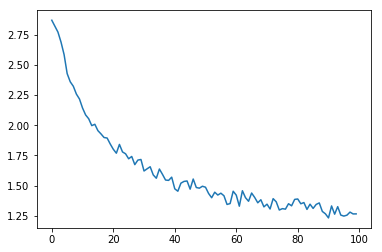

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

**Evaluating the Result**

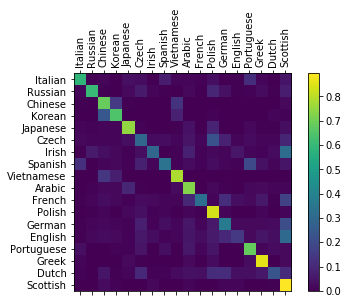

In [20]:
n_confusion = 10000
confusion_mat = torch.zeros(n_categories, n_categories)

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output


for i in range(n_confusion):
    category,line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    
    guess, guess_i = categoryFromOutput(output = output)
    category_i = all_categories.index(category)
    
    confusion_mat[category_i][guess_i] += 1
    
# Normalize the data accross a row in confusion matrix
for i in range(n_categories):
    confusion_mat[i] = confusion_mat[i] / confusion_mat[i].sum()
    
# Set up the plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_mat.numpy())
fig.colorbar(cax)

# Set up the axes
ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

# Force label at every ticks
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

**Running on User Input**

In [21]:
def predict(input_line, n_predictions = 3):
    print('--' * 50)
    print('{}'.format(input_line))
    
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        topv, topi = output.topk(n_predictions, dim = 1)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('({}) : {}'.format(value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
    
    return predictions

predict('Abreu')
predict('Afonso')
predict('Bruis')
predict('Brus')

----------------------------------------------------------------------------------------------------
Abreu
(-0.6249818801879883) : Portuguese
(-1.8793716430664062) : Spanish
(-2.5862555503845215) : German
----------------------------------------------------------------------------------------------------
Afonso
(-0.6704602241516113) : Italian
(-2.132704019546509) : Spanish
(-2.1994845867156982) : Japanese
----------------------------------------------------------------------------------------------------
Bruis
(-0.9184717535972595) : Arabic
(-1.1330018043518066) : Scottish
(-2.6703052520751953) : Portuguese
----------------------------------------------------------------------------------------------------
Brus
(-0.2171916365623474) : Portuguese
(-3.4353950023651123) : Spanish
(-3.4970176219940186) : Dutch


[[-0.2171916365623474, 'Portuguese'],
 [-3.4353950023651123, 'Spanish'],
 [-3.4970176219940186, 'Dutch']]

In [22]:
from bottle import route, run

@route('/<input_line>')
def index(input_line):
    return {'result': predict(input_line, 10)}

run(host='localhost', port=5533)

Bottle v0.12.13 server starting up (using WSGIRefServer())...
Listening on http://localhost:5533/
Hit Ctrl-C to quit.

127.0.0.1 - - [31/Jul/2018 11:57:39] "GET / HTTP/1.1" 404 720
127.0.0.1 - - [31/Jul/2018 11:57:39] "GET /favicon.ico HTTP/1.1" 200 347


----------------------------------------------------------------------------------------------------
favicon.ico
(-1.0286813974380493) : Portuguese
(-2.117703914642334) : Czech
(-2.3017642498016357) : Italian
(-2.4107065200805664) : Russian
(-2.4403269290924072) : Spanish
(-2.8265457153320312) : German
(-2.994394540786743) : Greek
(-3.411245822906494) : English
(-3.9691426753997803) : Scottish
(-3.9751083850860596) : French
----------------------------------------------------------------------------------------------------
Jackman
(-0.7812950015068054) : Scottish
(-1.7637760639190674) : English
(-2.1319079399108887) : Russian
(-2.836481809616089) : French
(-2.8891589641571045) : Czech
(-3.519850969314575) : Irish
(-3.543316125869751) : Greek
(-4.03550910949707) : German
(-4.178177833557129) : Japanese
(-4.2282280921936035) : Arabic
----------------------------------------------------------------------------------------------------
favicon.ico
(-1.0286813974380493) : Portuguese
(-2.1177

127.0.0.1 - - [31/Jul/2018 11:57:45] "GET /Jackman HTTP/1.1" 200 339
127.0.0.1 - - [31/Jul/2018 11:57:45] "GET /favicon.ico HTTP/1.1" 200 347


----------------------------------------------------------------------------------------------------
Mishra
(-0.9993343353271484) : Japanese
(-1.359426498413086) : Arabic
(-2.345374822616577) : Scottish
(-2.512455940246582) : Irish
(-3.039694309234619) : Czech
(-3.080331325531006) : Polish
(-3.656350612640381) : Portuguese
(-3.9653000831604004) : Italian
(-4.073171615600586) : Russian
(-4.074536323547363) : Spanish
----------------------------------------------------------------------------------------------------
favicon.ico
(-1.0286813974380493) : Portuguese
(-2.117703914642334) : Czech
(-2.3017642498016357) : Italian
(-2.4107065200805664) : Russian
(-2.4403269290924072) : Spanish
(-2.8265457153320312) : German
(-2.994394540786743) : Greek
(-3.411245822906494) : English
(-3.9691426753997803) : Scottish
(-3.9751083850860596) : French


127.0.0.1 - - [31/Jul/2018 11:58:43] "GET /Mishra HTTP/1.1" 200 343
127.0.0.1 - - [31/Jul/2018 11:58:43] "GET /favicon.ico HTTP/1.1" 200 347


----------------------------------------------------------------------------------------------------
Brothaigh
(-0.7266460657119751) : Russian
(-1.656032919883728) : Czech
(-2.1492927074432373) : Polish
(-2.571678638458252) : English
(-3.3735384941101074) : Irish
(-3.5828609466552734) : German
(-4.206081390380859) : Dutch
(-4.228754997253418) : Japanese
(-4.243834018707275) : Greek
(-4.37704610824585) : French
----------------------------------------------------------------------------------------------------
favicon.ico
(-1.0286813974380493) : Portuguese
(-2.117703914642334) : Czech
(-2.3017642498016357) : Italian
(-2.4107065200805664) : Russian
(-2.4403269290924072) : Spanish
(-2.8265457153320312) : German
(-2.994394540786743) : Greek
(-3.411245822906494) : English
(-3.9691426753997803) : Scottish
(-3.9751083850860596) : French


127.0.0.1 - - [31/Jul/2018 11:59:02] "GET /Brothaigh HTTP/1.1" 200 335
127.0.0.1 - - [31/Jul/2018 11:59:02] "GET /favicon.ico HTTP/1.1" 200 347


----------------------------------------------------------------------------------------------------
Kobayashi
(-0.7687544226646423) : Polish
(-1.0105351209640503) : Japanese
(-2.423795223236084) : Greek
(-3.401334524154663) : Russian
(-3.889617681503296) : Dutch
(-4.22165584564209) : Czech
(-5.201725006103516) : Scottish
(-5.630153179168701) : Italian
(-6.1735053062438965) : English
(-6.38984489440918) : Irish
----------------------------------------------------------------------------------------------------
favicon.ico
(-1.0286813974380493) : Portuguese
(-2.117703914642334) : Czech
(-2.3017642498016357) : Italian
(-2.4107065200805664) : Russian
(-2.4403269290924072) : Spanish
(-2.8265457153320312) : German
(-2.994394540786743) : Greek
(-3.411245822906494) : English
(-3.9691426753997803) : Scottish
(-3.9751083850860596) : French


127.0.0.1 - - [31/Jul/2018 11:59:25] "GET /Kobayashi HTTP/1.1" 200 336
127.0.0.1 - - [31/Jul/2018 11:59:25] "GET /favicon.ico HTTP/1.1" 200 347
